# Time Series

Based on the preparation done in [](02b-ndvi.ipynb), this section contains calculations of the NDVI for an entire year.

In [1]:
import geopandas as gpd
from multiprocessing import Pool
import numpy as np
from numpy import ma
from os import unlink
from pathlib import Path
import rasterio as r
from rasterio.features import geometry_window
import rasterio.mask
import rasterio.plot as rplt
from sentinel_helpers import scihub_band_paths, scihub_cloud_mask
from zipfile import BadZipFile

base_path = Path('resources/tempelhofer_feld/')
input_files = list(base_path.glob('*.zip'))
area_of_interest = gpd.read_file(base_path / 'tempelhofer_feld.geojson')
ndvi_path = base_path / 'ndvi'

# uncomment to remove previous calculations
# ! rm -rf {ndvi_path / '*.tif'}

Due to an unexpected failure of the Copernicus Open Access Hub API, several of the downloaded products were unusable due to data corruption.[^data_corruption] This is considered in the processing code by excluding the corrupted files.

Additionally, even though acceptable products were restricted in [](02a-data-retrieval.ipynb) to only those with a low cloud coverage, in some products clouds might still obscure the particular area of interest inside the products. If less than 50% of the area of interest is visible inside a particular product, the product is deemed to not contain enough usable data and skipped as well.

[^data_corruption]: See [](02a-data-retrieval-corrupted-zip-files.ipynb) for details.

## Data Processing

In [2]:
def normalize(v):
    return (np.clip(v, 0, 10_000) / 10_000).astype('f4') # ← four-byte-float / float32

def calculate_ndvi(product_path):
    global area_of_interest
    
    try:
        b04_path, b08_path = scihub_band_paths(product_path, ['B04', 'B08'], '10m')
        cloud_mask, _ = scihub_cloud_mask(product_path, area=area_of_interest)
    except BadZipFile:
        # This is due to a problem of Scihub
        print(f'{product_path}: Problem reading product, skipping it')
        return

    with r.open(b04_path, 'r') as b04, r.open(b08_path, 'r') as b08:
        # we want to only write the bare minimum data necessary to disk
        out_meta = b04.meta.copy()

        # we reproject the geojson file we fetched above and convert it so that rasterio
        # can use it as a mask; we subtract the cloud mask to avoid irregularities
        mask = area_of_interest.to_crs(out_meta['crs']).iloc[0].geometry
        window = geometry_window(b04, [mask])
        
        # update the dimensions and save as geotiff, not jp2
        out_meta.update({
            'width': window.width,
            'height': window.height,
            'driver': 'COG',
            'dtype': 'float32',
            'nodata': -999
        })    
        
        out_name = Path(b04_path).name.replace('B04', 'NDVI').replace('.jp2', '.tif')
        ndvi_path.mkdir(exist_ok=True, parents=True)
        
        # we need this to delete unusable files
        skip_file = False
        with r.open(ndvi_path / out_name, 'w+', **out_meta) as dst:
            # we take only the part out of our source raster that we actually need
            # crop=True clips off the borders
            b04, transform_b04 = rasterio.mask.mask(b04, shapes=[mask], filled=False, crop=True)
            b08, _ = rasterio.mask.mask(b08, shapes=[mask], filled=False, crop=True)
            
            # calculate area covered by clouds
            cloud_mask = cloud_mask[:,:b04.shape[1],:b04.shape[2]]
            unmasked_area = ~b04.mask
            clouds_on_unmasked_area = (cloud_mask & unmasked_area).sum()
            if clouds_on_unmasked_area > 0.5 * unmasked_area.sum():
                print(f'{product_path}: Area of interest covered by clouds, skipping it')
                skip_file = True
            else:
                b04 = normalize(b04)
                b08 = normalize(b08)

                # uncomment the following line to see if your masked shape looks correct
                #rplt.show(b04, transform=transform_b04)
                #rplt.show(b08, transform=transform_b04)

                # we want to be able to ignore divide by zero errors so the formula is nicer to write
                np.seterr(divide='ignore', invalid='ignore')
                ndvi = (b08 - b04) / (b08 + b04)
                ndvi.mask = b04.mask | cloud_mask

                # uncomment the following line to see if we calculated the index correctly
                # rplt.show(ndvi, transform=transform_b04)

                # write with explicit nodata value for masked pixels
                dst.write(ndvi.filled(out_meta['nodata']))
        if skip_file:
            # file has been created with r.open(..., 'w+'), so it needs to be
            # deleted explicitly
            unlink(ndvi_path / out_name)

In [3]:
%%time
from tqdm import tqdm
from multiprocessing import Pool

# we parallelize the NDVI calculation using a Python threadpool
with Pool() as pool:
    for _ in tqdm(pool.imap_unordered(calculate_ndvi, input_files), total=len(input_files)):
        # this loop is only here so we can display a progress bar
        pass

 18%|█▊        | 7/40 [00:03<00:19,  1.69it/s]

resources/tempelhofer_feld/S2A_MSIL2A_20190603T101031_N0212_R022_T33UUU_20190603T114652.zip: Problem reading product, skipping it
resources/tempelhofer_feld/S2A_MSIL2A_20190404T101031_N0211_R022_T32UQD_20190404T174806.zip: Problem reading product, skipping it
resources/tempelhofer_feld/S2A_MSIL2A_20190216T102111_N0211_R065_T33UUU_20190216T130428.zip: Problem reading product, skipping it


 35%|███▌      | 14/40 [00:04<00:09,  2.74it/s]

resources/tempelhofer_feld/S2B_MSIL2A_20190419T101029_N0211_R022_T33UUU_20190419T132322.zip: Problem reading product, skipping it


 42%|████▎     | 17/40 [00:05<00:08,  2.65it/s]

resources/tempelhofer_feld/S2A_MSIL2A_20190407T102021_N0211_R065_T33UUU_20190407T134109.zip: Problem reading product, skipping it


 48%|████▊     | 19/40 [00:05<00:06,  3.35it/s]

resources/tempelhofer_feld/S2B_MSIL2A_20190512T102029_N0212_R065_T33UUU_20190512T134103.zip: Problem reading product, skipping it


 62%|██████▎   | 25/40 [00:07<00:05,  2.73it/s]

resources/tempelhofer_feld/S2A_MSIL2A_20190613T101031_N0212_R022_T33UUU_20190614T125329.zip: Problem reading product, skipping it
resources/tempelhofer_feld/S2A_MSIL2A_20190424T101031_N0211_R022_T32UQD_20190424T162325.zip: Problem reading product, skipping it


 70%|███████   | 28/40 [00:08<00:03,  3.51it/s]

resources/tempelhofer_feld/S2A_MSIL2A_20190822T101031_N0213_R022_T32UQD_20190822T143621.zip: Problem reading product, skipping it
resources/tempelhofer_feld/S2A_MSIL2A_20190623T101031_N0212_R022_T33UUU_20190623T132509.zip: Problem reading product, skipping it


100%|██████████| 40/40 [00:11<00:00,  3.49it/s]

CPU times: user 77.4 ms, sys: 154 ms, total: 231 ms
Wall time: 11.6 s


How many files could be processed?

In [4]:
! ls -l {ndvi_path / '*.tif'} | wc -l

30


In order to be able to re-use designated subsections, the `rio` command-line-tool provided by `rasterio` is used to unify the target CRS.

In [5]:
%%time

for file_name in ndvi_path.glob('*.tif'):
    if 'T33UUU' in file_name.name:
        continue
    
    # crs from the previous notebook to re-use the designated areas
    out_name = str(file_name).replace("T32UQD", "T33UUU")
    ! rio warp --dst-crs EPSG:32633 --overwrite {file_name} {out_name} && rm {file_name}

CPU times: user 294 ms, sys: 435 ms, total: 729 ms
Wall time: 35 s


## Visualization

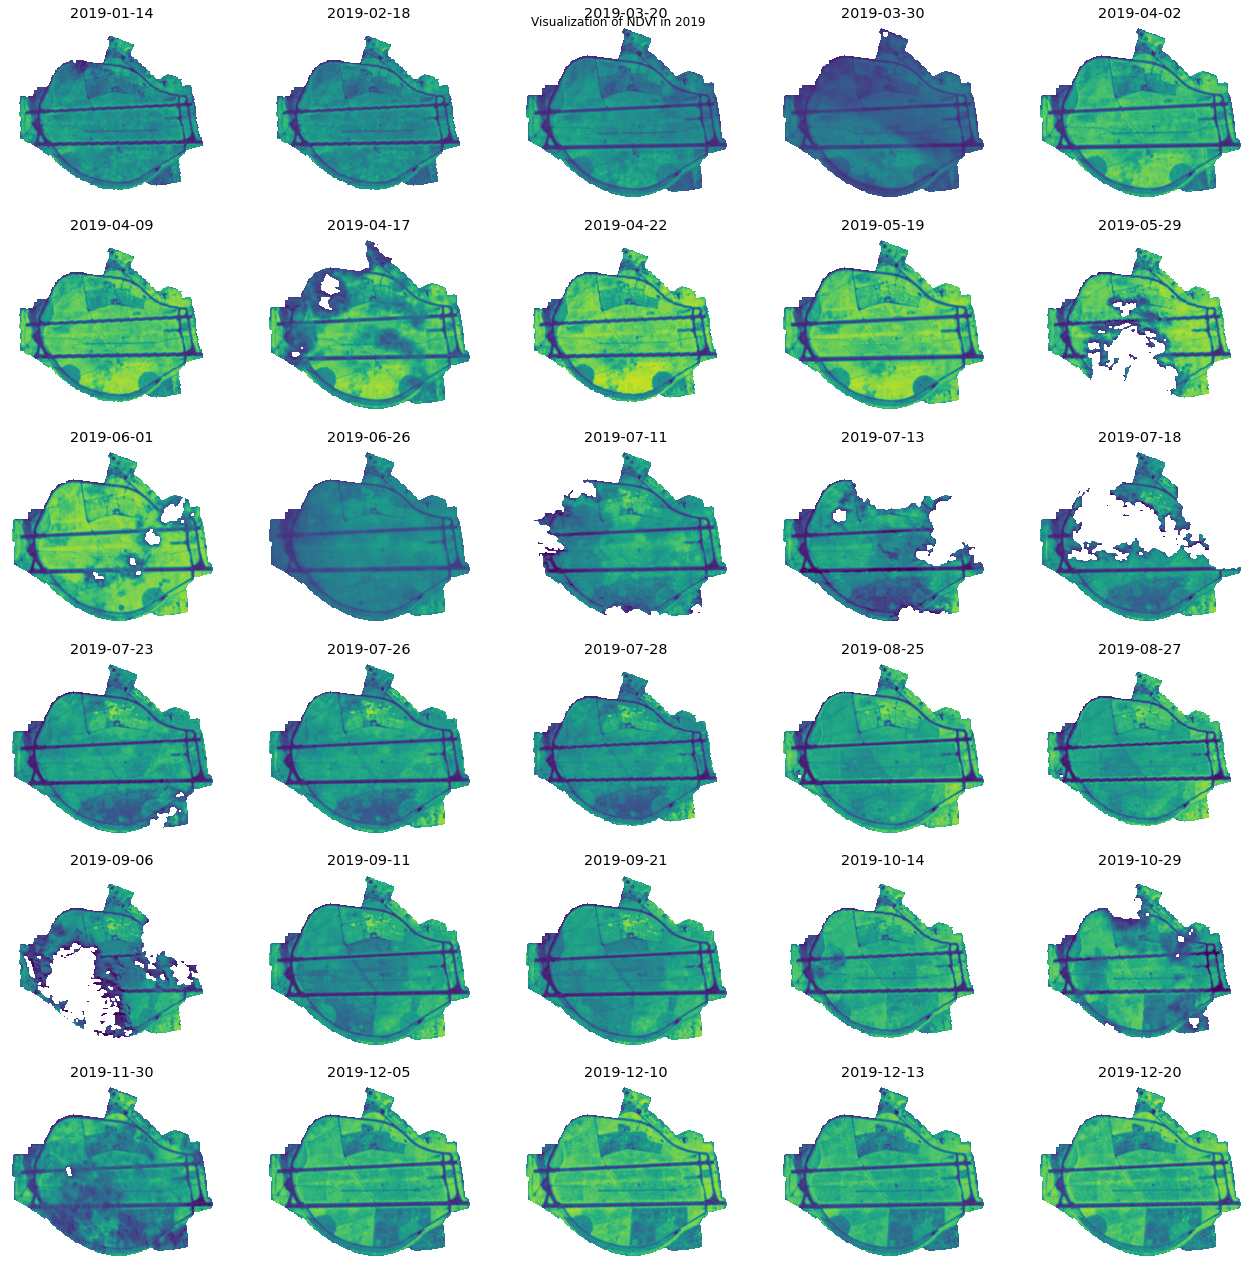

In [6]:
import math
from matplotlib import pyplot as plt
from sentinel_helpers import scihub_band_date

output_files = sorted(ndvi_path.glob('*.tif'))

ncols = 5
fig, axs = plt.subplots(nrows=math.ceil(len(output_files) / ncols), ncols=ncols, figsize=(18,18))
fig.tight_layout(h_pad=2)
axs = axs.flatten() 

for ax, file in zip(axs, output_files):
    with r.open(file) as src:
        date = scihub_band_date(file)
        ax.set_title(date.strftime('%Y-%m-%d'), pad=10)
        rplt.show(src, vmin=0, vmax=1, ax=ax)
        
        ax.grid(False) # hide background gird
        ax.set_xticks([]) # hide x and y ticks and tick labels
        ax.set_yticks([])

# hide empty subplots
for ax in axs[len(output_files):]:
    ax.axis('off')

In [7]:
%%time

def average(file_path):
    with r.open(file_path) as src:
        # masked=True makes sure to respect the nodata value and reads the data
        # as a numpy MaskedArray, which lets us use `numpy.ma`'s methods
        data = src.read(1, masked=True)
        avg = ma.average(data)
        return file_path, avg
    
averages = list(map(average, output_files))

CPU times: user 146 ms, sys: 20.2 ms, total: 166 ms
Wall time: 164 ms


The pandas data-processing library is used to plot the NDVI over the whole year:

<AxesSubplot:>

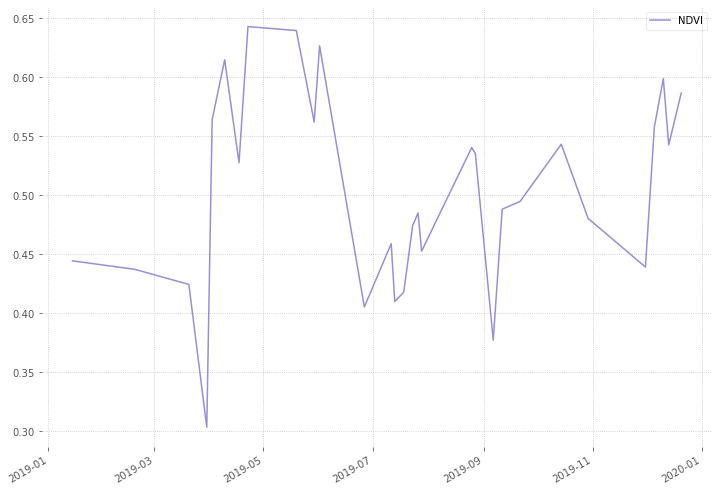

In [8]:
import pandas as pd

paths, ndvi_avg = zip(*averages)

# parse capture date from file name
dates = map(lambda p: p.name.split('_')[1], paths)

df = pd.DataFrame({'NDVI': ndvi_avg}).set_index(pd.DatetimeIndex(dates))
df.plot(figsize=(12,9))

While there seems to be a dip following the summer months, interpretation is prone to errors by looking at this data alone. There is no information on local fauna, on weather phenomena, or other factors besides cloud cover and spectral band  reflectivity. Some of this can be inferred by looking at the individual year-long plots above, but this alone can for example not explain the difference in values at the beginning and at the end of the time span, both of which are during winter. It is therefore important to note that while the data may be useful, it can not be adequately explained in its entirety without any expertise on the field.